# Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.np_utils import to_categorical

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Dense, Flatten, BatchNormalization, MaxPooling2D,LeakyReLU
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.utils.np_utils import to_categorical
from tensorflow.keras.regularizers import l2
from keras.losses import CategoricalCrossentropy

import warnings
warnings.filterwarnings('ignore')

## For Colab Notebooks ONLY !!!

*Used for importing dataset directly from kaggle to colab. No need to download dataset from kaggle, upload to google drive and then working in colab notebooks anymore. This is a way more efficient way*

In [2]:
! pip install --upgrade --force-reinstall --no-deps kaggle
import os
from google.colab import files

     |████████████████████████████████| 61kB 4.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=e480194c5d2002230b7e6f9a1531ffc754c245f95be3676a7623b7a6f9b22dc2
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [3]:
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
! kaggle competitions download -c Kannada-MNIST
zip_obj = zipfile.ZipFile(r'/content/Kannada-MNIST.zip' , 'r')
zip_obj.extractall('DataSet')
os.remove(r"/content/Kannada-MNIST.zip")
os.remove(r"/content/kaggle.json")

  0% 0.00/12.4M [00:00<?, ?B/s]
100% 12.4M/12.4M [00:00<00:00, 139MB/s]


# Import Data

In [5]:
train = pd.read_csv(r"/content/DataSet/train.csv")
val = pd.read_csv("/content/DataSet/Dig-MNIST.csv")
train = pd.concat([train, val], ignore_index=True)

In [6]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
train.shape

(70240, 785)

# Train, Validation and Test Split

In [8]:
train, val = train_test_split(train, train_size=40000, random_state=42, stratify=train.iloc[:,0])
val, test = train_test_split(val, train_size=20000, random_state=42, stratify=val.iloc[:,0])
train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)
print(train.shape)
print(val.shape)
print(test.shape)

(40000, 785)
(20000, 785)
(10240, 785)


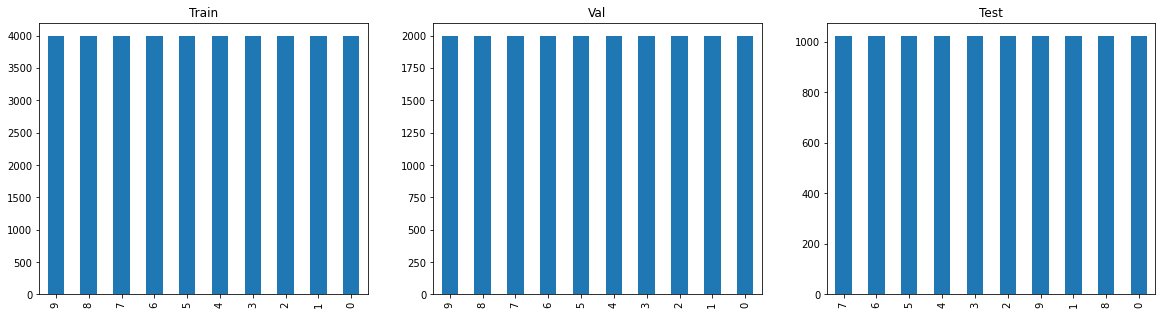

In [9]:
fig = plt.figure(figsize=(20, 5))

rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
train["label"].value_counts().plot(kind="bar")
plt.title("Train")

fig.add_subplot(rows, columns, 2)
val["label"].value_counts().plot(kind="bar")
plt.title("Val")

fig.add_subplot(rows, columns, 3)
test["label"].value_counts().plot(kind="bar")
plt.title("Test")
plt.show()

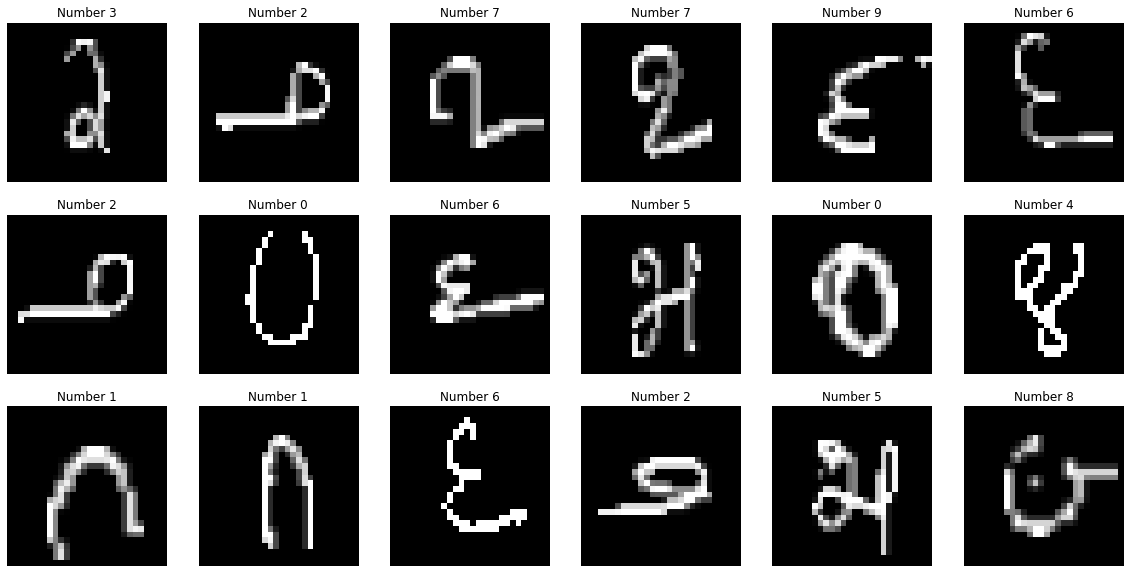

In [10]:
fig = plt.figure(figsize=(20, 10))

rows = 3
columns = 6

for i in range(1, rows*columns+1):
    fig.add_subplot(rows, columns, i)
    num = np.random.randint(0, len(train))
    img = train.iloc[num , 1:].values.reshape(28,28)
    plt.imshow(img, cmap='gist_gray')
    plt.axis('off')
    plt.title(f"Number {train.loc[num , 'label']}")
plt.show()

# Reshaping Data

In [11]:
train_images = train.iloc[:, 1:].values.reshape(len(train), 28, 28, 1) / 255
train_labels = to_categorical(train.iloc[:, 0].values, num_classes = 10)

val_images = val.iloc[:, 1:].values.reshape(len(val), 28, 28, 1) / 255
val_labels = to_categorical(val.iloc[:, 0].values, num_classes = 10)

test_images = test.iloc[:, 1:].values.reshape(len(test), 28, 28, 1) / 255
test_labels = test.iloc[:, 0].values

In [12]:
print(train_images.shape)
print(train_labels.shape)
print(val_images.shape)
print(val_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(40000, 28, 28, 1)
(40000, 10)
(20000, 28, 28, 1)
(20000, 10)
(10240, 28, 28, 1)
(10240,)


# Train Image Data Generator

In [13]:
train_datagen = ImageDataGenerator(rotation_range=20, shear_range = 10 , fill_mode = 'nearest' ,
                                   zoom_range = 0.4, width_shift_range=0.25, height_shift_range=0.25)

train_set = train_datagen.flow(train_images, train_labels, batch_size = 50)

# CallBacks

In [14]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.990):
            print("\nReached 99.0% accuracy so cancelling training!")
            self.model.stop_training = True

LR_reduce = ReduceLROnPlateau(monitor='val_accuracy' , factor=.5 , patience=6 , min_lr=.000001 , verbose=1)

ES_monitor = EarlyStopping(monitor='val_loss' , patience=10)

**CNN Model**

In [15]:
callbacks = myCallback()

tf.keras.backend.clear_session()
tf.random.set_seed(0)
tf.compat.v1.set_random_seed(0)
np.random.seed(0)

model = Sequential()

model.add(Conv2D(64, (3,3), padding='same', input_shape=(28, 28, 1)))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64,  (3,3), padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64,  (3,3), padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(128,  (3,3), padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(128,  (3,3), padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3,3), padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(256,  (3,3), padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=RMSprop(lr=0.0025), loss=CategoricalCrossentropy(label_smoothing=0.1), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        3

In [16]:
history = model.fit(train_set, validation_data = (val_images, val_labels), validation_batch_size=500,
                    epochs=50, verbose=1, callbacks=[callbacks, LR_reduce, ES_monitor], batch_size=1024)

Epoch 1/50
800/800 [==============================] - 56s 27ms/step - loss: 1.3670 - accuracy: 0.6511 - val_loss: 0.7068 - val_accuracy: 0.9600
Epoch 2/50
800/800 [==============================] - 20s 26ms/step - loss: 0.7483 - accuracy: 0.9124 - val_loss: 0.6237 - val_accuracy: 0.9798
Epoch 3/50
800/800 [==============================] - 20s 25ms/step - loss: 0.6841 - accuracy: 0.9375 - val_loss: 0.6084 - val_accuracy: 0.9669
Epoch 4/50
800/800 [==============================] - 20s 25ms/step - loss: 0.6594 - accuracy: 0.9421 - val_loss: 0.5532 - val_accuracy: 0.9869
Epoch 5/50
800/800 [==============================] - 20s 25ms/step - loss: 0.6445 - accuracy: 0.9489 - val_loss: 0.5514 - val_accuracy: 0.9880
Epoch 6/50
800/800 [==============================] - 20s 25ms/step - loss: 0.6278 - accuracy: 0.9528 - val_loss: 0.5471 - val_accuracy: 0.9894
Epoch 7/50
800/800 [==============================] - 20s 25ms/step - loss: 0.6231 - accuracy: 0.9558 - val_loss: 0.5380 - val_accuracy:

**Data Accuracy and Loss Plotting**

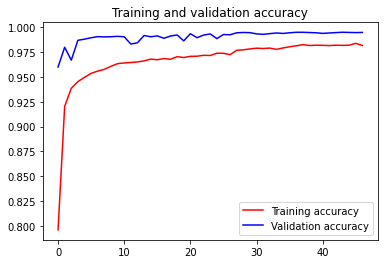

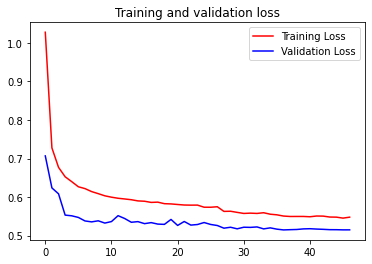

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Prediction**

In [18]:
prediction = model.predict(test_images)
output = list(np.argmax(prediction , axis=1))

In [19]:
print(classification_report(test_labels, output))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1024
           1       0.99      1.00      0.99      1024
           2       1.00      1.00      1.00      1024
           3       0.99      1.00      1.00      1024
           4       1.00      1.00      1.00      1024
           5       1.00      1.00      1.00      1024
           6       0.99      0.99      0.99      1024
           7       0.99      0.99      0.99      1024
           8       1.00      1.00      1.00      1024
           9       1.00      0.99      1.00      1024

    accuracy                           1.00     10240
   macro avg       1.00      1.00      1.00     10240
weighted avg       1.00      1.00      1.00     10240



In [20]:
print(confusion_matrix(test_labels, output))

[[1014    9    1    0    0    0    0    0    0    0]
 [   4 1020    0    0    0    0    0    0    0    0]
 [   0    1 1021    2    0    0    0    0    0    0]
 [   1    0    0 1022    0    0    0    1    0    0]
 [   0    0    0    0 1022    1    0    0    1    0]
 [   0    0    0    1    1 1022    0    0    0    0]
 [   0    0    1    0    0    0 1017    5    0    1]
 [   0    1    0    4    0    0    3 1016    0    0]
 [   0    0    0    0    0    0    1    0 1023    0]
 [   0    0    0    0    1    0    6    0    0 1017]]


# Saving Model

In [24]:
model.save(r'/content/my_model')

INFO:tensorflow:Assets written to: /content/my_model/assets
